## PHY 410
### GPS Final Project
### Jeremy Kazimer

***

### Import Statements

In [33]:
# Python libraries:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
from scipy.optimize import fmin_bfgs
import cv2

# My utility libraries:
from get_data import *
from geographical_to_cartesian import *

### Motivation

In a society enriched by technology, it's inevitable that [`GPS`](https://en.wikipedia.org/wiki/Global_Positioning_System) will become increasingly commonplace.  Not far does one have to go to find an application, like Facebook or, oddly enough, [Angry Birds](https://www.vox.com/explainers/2019/5/7/18273355/angry-birds-phone-games-data-collection-candy-crush), that takes advantage of location information.  

The unavoidable reality is that this technology is ubiquitous, that privacy as a consumer is dwindling.  With the technology being everywhere, being ubiquitous, this also means that tools in order to analyze this data are more available.

Hence, tools like `phyphox` provide a means of recording your own coordinate data, exporting it in a rather limited (but understandable, given data format conventions) variety of file formats.  

Coordinate data is inherently fascinating; in its raw form, you know exactly where that person is based on the [geographical coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system).  However, as with any data, one set of points is rather boring; it tells you minimum information.  As such, it's more interesting to observe a change in this data.  For something like `GPS`, this is motion.  

Seeing how position changes as a function of a generic coordinate system (and predicting it, via fitting algorithms) is the most obvious application of such data.  As such, this is the motivation of this project:  to observe how my location changes across different trips, all localized within a few miles of my residence.  We can also observe quantities such as velocity, acceleration, jerk, [snap, crackle, and pop](https://en.wikipedia.org/wiki/Fourth,_fifth,_and_sixth_derivatives_of_position).

### Background Information

Before we begin analyzing any data, it's important to establish some groundwork.

First, all data comes from [phyphox](https://phyphox.org/), an application that turns your smartphone into a "mobile lab."  There are a variety of experiments listed on their website, but the one we're most concerned with, of course, is their GPS experiment.  Really, all they do here is record your position as discrete variables of altitude (m), latitude (°), and longitude (°).  Alongside this, the standard deviation of horizontal and vertical position (m) are provided.  They also provide information on velocity and acceleration.

Second, the data for these results are provided in `CSV` and `Excel` formats.  I opt to use `CSV` because that data form is overall more accessible and less bulky.  

Third, most of the background data processing is done in my own custom made `.py` files.  For two reasons, really:  that the code is out of sight so more of the space can be used for discussion and that unit testing can be performed on some of the statistically invariate functions.  A deeper dive into this code (and the code in this notebook) can be found in the `readme` in the github. 

Fourth, all data can be found in the `data` folder and the figures in the `figures` folder.  This is an act of cleanliness. 

PUT MORE IF NEEDED.



### Theory

### Experiments
##### Converting the data to a sensible form

We begin the experiments by first loading a random dataset from the set of four files I recorded on December 3rd, 2020:

In [34]:
# np.random.choice([1, 2, 3, 4]) picks an integer randomly from 1 - 4.
# .format() inserts that choice into the string at {}
filename = 'data/sample_{}.csv'.format(np.random.choice([1, 2, 3, 4]))

print('working file: {}'.format(filename))

working file: data/sample_1.csv


Then, using my first helper library `get_data`, we load in the data in the form of a dictionary storing all the information that we care about:

In [35]:
position_dictionary = get_data(filename)

In [36]:
# Printing the keys, just to show what was stored:
print(position_dictionary.keys())

dict_keys(['time', 'latitude', 'longitude', 'altitude', 'z std', 'x & y std'])


Just to see the data in the geographical coordinate system, we can plot the main variables first as a function of time, then each other:

In [37]:
# Fetching the appropriate variables.
time = position_dictionary['time']

latitude = position_dictionary['latitude']
longitude = position_dictionary['longitude']
altitude = position_dictionary['altitude']

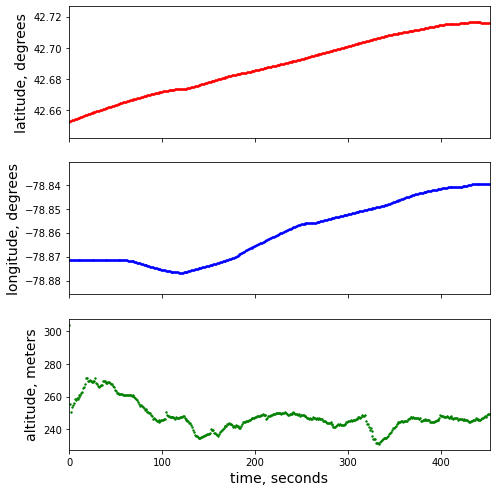

In [38]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, latitude, s = 2, c = 'red')
axs[1].scatter(time, longitude, s = 2, c = 'blue')
axs[2].scatter(time, altitude, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('latitude, degrees', fontsize = 14)
axs[1].set_ylabel('longitude, degrees', fontsize = 14)
axs[2].set_ylabel('altitude, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_geographical_plot.pdf')

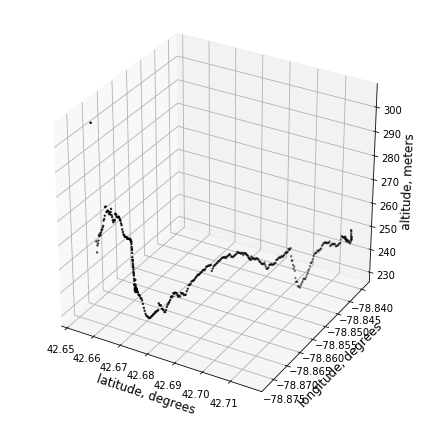

In [39]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(latitude, longitude, altitude, s = 2, c = 'k')

# Labels:
ax.set_xlabel('latitude, degrees', fontsize = 12)
ax.set_ylabel('longitude, degrees', fontsize = 12)
ax.set_zlabel('altitude, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_geographical_plot.pdf')

# Sorry for the "longitude" label.  I couldn't seem to move it.

This plot is fine and all, but, aforementioned, it means nothing to the average person for two reasons.  First, that it's in an unconventional coordinate system for everyday use.  We can address this by converting the system to Cartesian.  For this, we'll use the `geographical_to_cartesian` library (see *Theory* for explanation):

In [40]:
cartesian_system = convert_coordinates(latitude, longitude, altitude)

In [41]:
# Once again, printing the keys for convenience.
print(cartesian_system.keys())

dict_keys(['x', 'y', 'z'])


In [42]:
x, y, z = cartesian_system['x'], cartesian_system['y'], cartesian_system['z']

We can now repeat the same plots above, but for the new coordinate system:

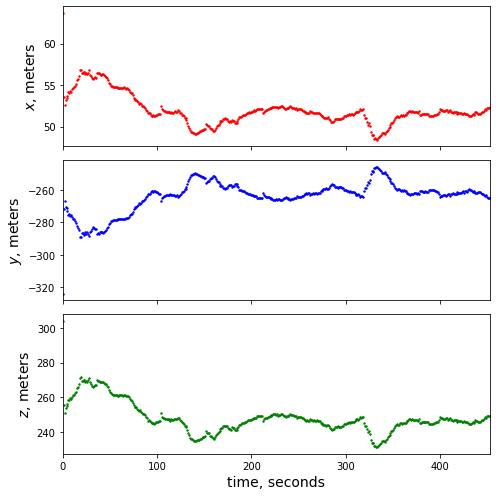

In [43]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, x, s = 2, c = 'red')
axs[1].scatter(time, y, s = 2, c = 'blue')
axs[2].scatter(time, z, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$x$, meters', fontsize = 14)
axs[1].set_ylabel('$y$, meters', fontsize = 14)
axs[2].set_ylabel('$z$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_cartesian_plot.pdf')

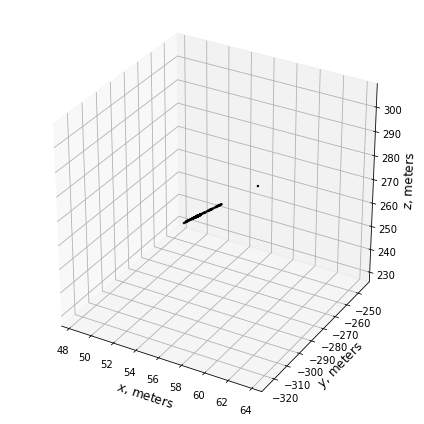

In [44]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(x, y, z, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$x$, meters', fontsize = 12)
ax.set_ylabel('$y$, meters', fontsize = 12)
ax.set_zlabel('$z$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_cartesian_plot.pdf')

This is fine.  With a little more knowledge, the user can understand that they're moving away from their starting point.  However, my second concern arises:  although it's fine that the origin is not defined by the starting point, it doesn't make much sense to not shift the data to the starting point.

To me, this is because shifting to the origin tells the user a lot more information without additional thought.  For example, "you are 10 meters down from home" is more sensical than "you are at 250 meters in the $z$".  

As such, the conversion is generically $dn = n - n_0$, where $n$ is any generic position variable and $n_0$ is the first point in this set.  Then, $dn$ is simply the change in that variable at any given point.  In Python:

In [45]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]

And a demonstrative plot:

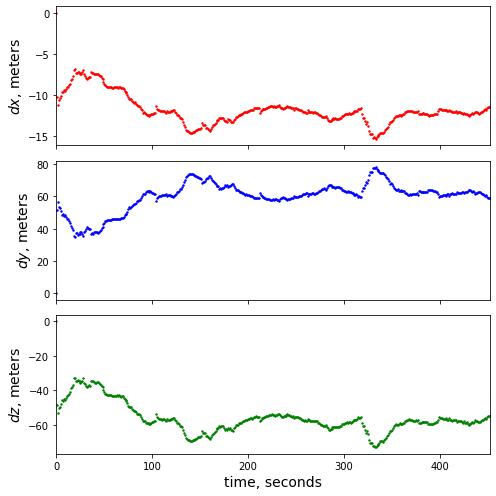

In [46]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_relative_cartesian_plot.pdf')

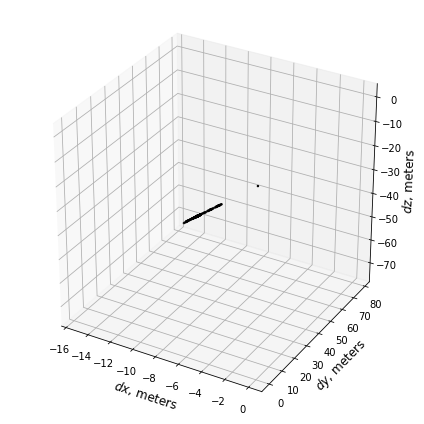

In [47]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_relative_cartesian_plot.pdf')

As suggested, the structure of the data doesn't really change that much (see _Theory_ for more).  To me, this is more interpretable for the average person.  Of course, it's unrealistic that the average person will see this, but it's far more reasonable to cater to the average than to the deviations.

Now, since we've established our coordinate system, we can begin fitting the data.

##### Fitting the data

The question then arises of how to fit the data.  First, it depends on what exactly is being predicted.  In the most basic case, $f(t)$ is a useful quantity to predict - it tells you where you should be as a function of time.  

Since time is purely linear (although this year has felt the opposite), a `BFGS` [algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) would be an ideal fit.  This is because motion is a generically quadratic function (ignoring higher motion, since it's usually not observed on a large scale; see more in _Theory_).  As such, we can treat the quadratic coefficients $(a, b, c)$ as variables of their own, since our data isn't changing.

Then, we can seek to optimize those coefficients such that $\chi^2 = \sum_i^N\left[\dfrac{s_i - at_i^2 - bt_i - c}{\sigma_i}\right]^2$ is its own minimum or maximum. Since the equation is quadratic, there's a guaranteed local minimum or maximum.  

Thus, it is necessary to take the partial derivative with respect to all the active variables.  These are passed into the `BFGS` algorithm as the gradient.  Otherwise, the choices of $(a, b, c)$ as an initial prediction are arbitrary, as long as they're localized within the data.  A further explanation, and the gradients, can be found in _Theory_ (as always).

So, first, a predictor of basic rectilinear motion, starting with the function and its gradients:

In [167]:
def f(coefficients):
    
    a, b, c = coefficients
    
    # We can just initialize ds differently for each function call.
    chi = a*time**2 + b*time + c - ds
    chi = chi/std_ds
    
    return np.sum(chi**2)

In [168]:
def df(coefficients):

    a, b, c = coefficients
    
    # We can just initialize ds differently for each function call.
    chi = a*time**2 + b*time + c - ds
    chi = chi/std_ds**2
    
    df0 = 2*np.sum(time**2 * chi)
    df1 = 2*np.sum(time * chi)
    df2 = 2*np.sum(chi)
    
    return np.array([df0, df1, df2])

Then a callback function, in case the optimization path needs to be accessed:

In [169]:
# From the bfgs notebook:
def make_minimize_cb(path=[]):    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))
    return minimize_cb

We can generate a generic function such that:

In [170]:
def bfgs_minimize():
    
    # We define initial conditions in the path variable
    p = [1, 1, 1]
    path = [p]

    # A tolerance such that the function breaks if under.
    gtol = 1e-10

    # Utilizing the SciPy library instead of typing it myself.  
    bfgs_coefficients = fmin_bfgs(f = f, fprime = df, 
                                  x0 = p, gtol = gtol, callback = make_minimize_cb(path))
    
    return bfgs_coefficients, path

Now, a test run:

In [171]:
# By putting it in an array, we don't have to repeat code.
ds_array = [dx, dy, dz]

# Recall that position_dictionary came from the beginning and 
# stores the std's alongside the geographical coordinates.
std_array = [position_dictionary['x & y std'], 
             position_dictionary['x & y std'],
             position_dictionary['z std']]

# 3 coefficients, 3 dimensions.
coefficients = np.zeros((3, 3))

for idx, ds in enumerate(ds_array):

    std_ds = std_array[idx]

    quadratic_coefficients, _ = bfgs_minimize()
    
    coefficients[idx] = quadratic_coefficients

         Current function value: 50.819779
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 13
         Current function value: 1288.386499
         Iterations: 9
         Function evaluations: 16
         Gradient evaluations: 15
         Current function value: 1456.017276
         Iterations: 8
         Function evaluations: 38
         Gradient evaluations: 26


And now, a simple plot as demonstration:

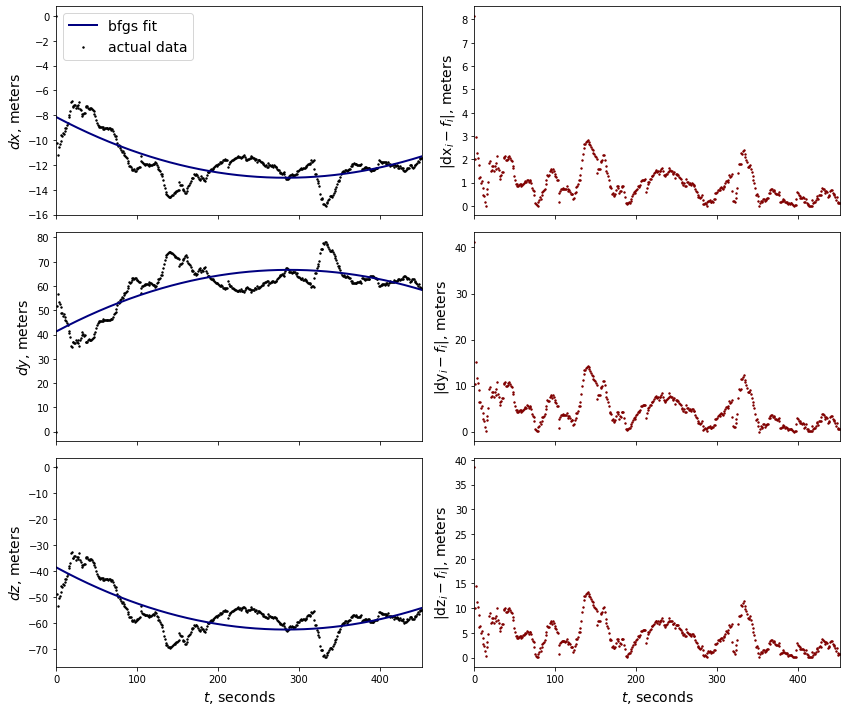

In [214]:
labels = [r'$dx$', r'$dy$', r'$dz$']

fig, axs = plt.subplots(3, 2, sharex = True, figsize = (12, 10))
bfgs_array = []
for idx, label in enumerate(labels):
    
    # Pulling the prediction:
    a, b, c = coefficients[idx]
    bfgs_fit = a*time**2 + b*time + c
    bfgs_array.append(bfgs_fit)
    
    # First, the comparison of functions:
    axs[idx][0].scatter(time, ds_array[idx], s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(time, bfgs_fit, lw = 2, c = 'navy', label = 'bfgs fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(time, abs(ds_array[idx] - bfgs_fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$t$, seconds', fontsize = 14)
        axs[idx][1].set_xlabel('$t$, seconds', fontsize = 14)
    
    axs[idx][0].set_xlim(time[0], time[-1])
    axs[idx][1].set_xlim(time[0], time[-1])
    
axs[0][0].legend(loc = 'upper left', fontsize = 14)
    
fig.tight_layout()

So, the accuracy is apparent.  Hint:  it's not very good.  It finds the general shape of the distribution, but we can do much better.  Intuitively, one way to improve upon this method is to generalize `BFGS` for $n$-dimensions.  However, this becomes trivial as higher order terms will cause the `scipy` implementation to reach integer overflow rather quickly.  At most, one could implement a 3rd or 4th order polynomial.  So, our approximation is limited by machine precision and truncation.  A traditional matrix least-squares also falls into the same problem.  It also has the issue of linearizing the data when the data isn't necessarily linear.  

Regardless, we could also consider a Fourier Transform of sorts, but the success of that methods relies on the data being periodic in nature.  Although some of our samples appear so, that doesn't mean every other data will follow the same trends.  So, it might produce an accurate fit in one case, but not all.

For now, the time-dimensional case is as accurate as it's going to get.

### Discussion

In [212]:
time.shape

(453,)

In [217]:
len(bfgs_array)

3

In [219]:
r0 = np.sqrt(dx**2 + dy**2 + dz**2)

In [225]:
A = np.array((np.ones(len(dx)), dx, dy, dz)).T
a, b, c, d = np.linalg.solve(A.T @ A, A.T @ r0)

### Notes

In [234]:
b, c, d

(-0.13993140685135178, 0.7234329468176595, -0.6760669661084813)

https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704-ep713_multivariablemethods/bs704-ep713_multivariablemethods2.html

In [197]:
A = np.array((np.ones(len(time)), time, time**2)).T

In [198]:
AtA = (A.T @ A)
Atb = (A.T @ dx)

In [199]:
c_3

-0.0009068530098838514

In [200]:
c_1

-7.625491838460604

In [201]:
c_1, c_2, c_3 = np.linalg.solve(AtA, Atb)

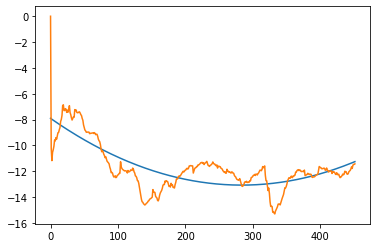

In [205]:
plt.plot((c_1 + c_2*time + c_3*time**2))
plt.plot((dx))

In [ ]:
plt.plot(time, ds - (c_1 + c_2*dx + c_3*dy + c_4*dz))